## 1. Импорт необходимых библиотек

- **sklearn** — обучение моделей, стандартные метрики, подготовка данных.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

## 2. Генерация синтетического набора данных

In [2]:
np.random.seed(146)

n = 500

# Генерация признаков
rooms = np.random.normal(6, 1, n)           # количество комнат
distance = np.random.uniform(1, 10, n)      # расстояние до центра
age = np.random.uniform(0, 100, n)          # возраст дома
crime = np.random.exponential(0.5, n)       # уровень преступности
lowstatus = np.random.uniform(2, 30, n)     # % населения низкого статуса

# Формируем целевую переменную
price = 50 + rooms*8 - distance*2 - crime*5 - lowstatus*1.5 + np.random.normal(0, 5, n)

df = pd.DataFrame({
    'rooms': rooms,
    'distance': distance,
    'age': age,
    'crime': crime,
    'lowstatus': lowstatus,
    'price': price
})

df.head()

,rooms,distance,age,crime,lowstatus,price
0,8.396479,1.358920,42.437419,0.005884,6.914749,105.176479
1,5.961897,9.797092,90.114864,0.235826,23.252338,32.493120
2,4.946477,1.848741,8.793500,0.317963,21.555528,49.588525
3,5.118696,2.200512,7.216841,0.046824,5.630724,79.452638
4,6.688067,8.766453,35.750118,0.817633,14.506054,58.359570


## 3. Проверка структуры данных
Используем `.info()` и `.isnull()`.

### Зачем?
- Убедиться, что признаки числовые.
- Проверить, нет ли пропусков.
- Это обязательный этап перед обучением моделей.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   rooms      500 non-null    float64
 1   distance   500 non-null    float64
 2   age        500 non-null    float64
 3   crime      500 non-null    float64
 4   lowstatus  500 non-null    float64
 5   price      500 non-null    float64
dtypes: float64(6)
memory usage: 23.6 KB


In [4]:
df.isnull().sum()

rooms        0
distance     0
age          0
crime        0
lowstatus    0
price        0
dtype: int64

## 4. Корреляционная матрица
Корреляция показывает, **как линейно связаны признаки**.

In [5]:
corr_matrix = df.corr()
corr_matrix

,rooms,distance,age,crime,lowstatus,price
rooms,1.000000,-0.042032,0.043233,-0.000455,0.017019,0.477369
distance,-0.042032,1.000000,0.008011,-0.011850,0.012056,-0.346906
age,0.043233,0.008011,1.000000,0.016395,-0.000503,0.016638
crime,-0.000455,-0.011850,0.016395,1.000000,-0.036110,-0.111511
lowstatus,0.017019,0.012056,-0.000503,-0.036110,1.000000,-0.734651
price,0.477369,-0.346906,0.016638,-0.111511,-0.734651,1.000000


### Визуализация корреляции — Heatmap

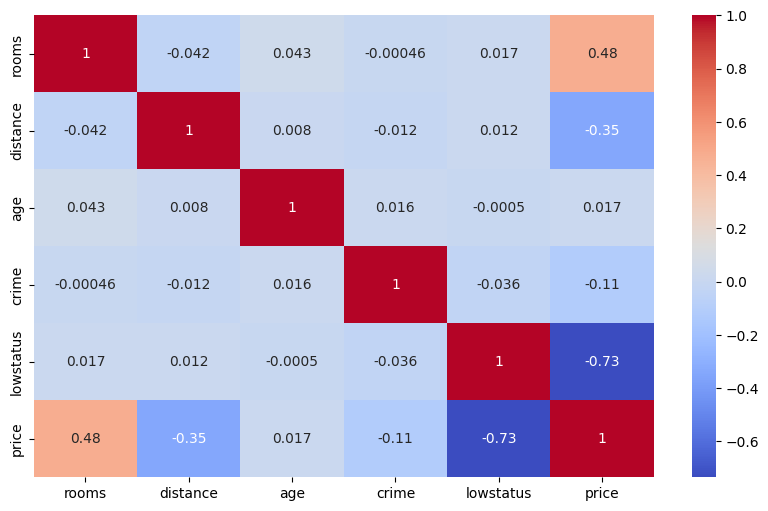

In [6]:
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

## 5. Выбор признаков для модели
Мы выбираем признаки, которые сильнее всего коррелируют с целевой переменной `price`.

- Модель обучается быстрее.
- Меньше риск переобучения.
- Легче визуализировать зависимости.

In [7]:
corr_matrix['price'].sort_values(ascending=False)

price        1.000000
rooms        0.477369
age          0.016638
crime       -0.111511
distance    -0.346906
lowstatus   -0.734651
Name: price, dtype: float64

## 6. Диаграммы рассеяния (scatter plots)
Помогают визуально определить форму зависимости — линейная ли она.

Линейная регрессия хорошо работает только когда связь похожа на прямую линию.

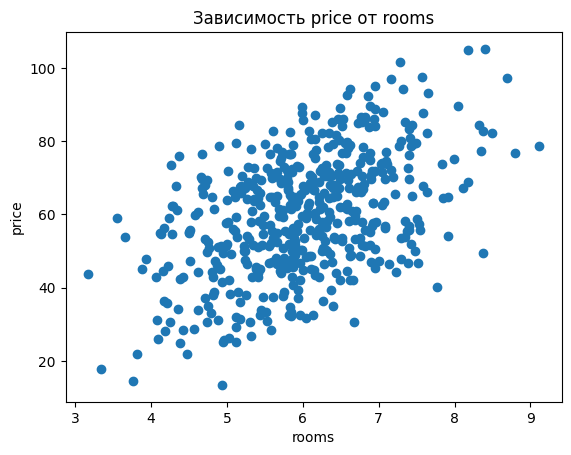

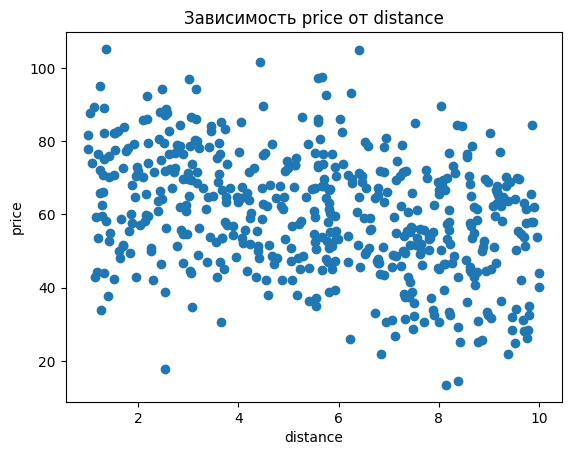

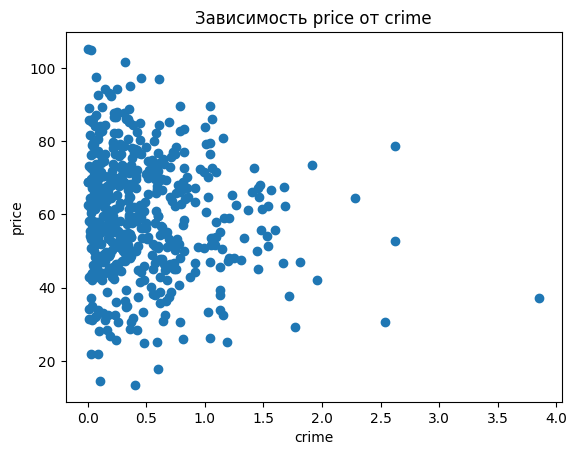

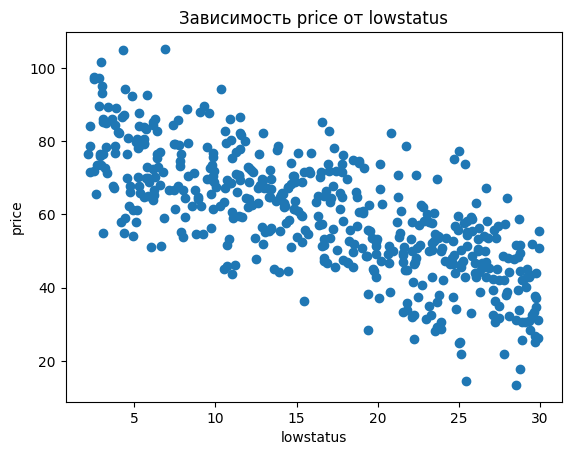

In [8]:
features = ['rooms', 'distance', 'crime', 'lowstatus']

for f in features:
    plt.scatter(df[f], df['price'])
    plt.xlabel(f)
    plt.ylabel('price')
    plt.title(f'Зависимость price от {f}')
    plt.show()

## 7. Разделение данных на train/test
Используем `train_test_split`.

Для оценки модели на данных, которые она **не видела при обучении**.

In [9]:
X = df[features]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=146
)

## 8. Линейная регрессия
Базовая модель, которая ищет зависимость в виде прямой линии.

- Простая
- Интерпретируемая
- Быстрая

In [10]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

(
    r2_score(y_train, pred_train),
    r2_score(y_test, pred_test),
    np.sqrt(mean_squared_error(y_test, pred_test))
)

(0.9024944312065091, 0.8934310311873492, np.float64(5.42635864833284))

## 9. Boxplot целевого признака — поиск выбросов
Выбросы — аномально большие или маленькие значения.

Они могут исказить параметры модели.

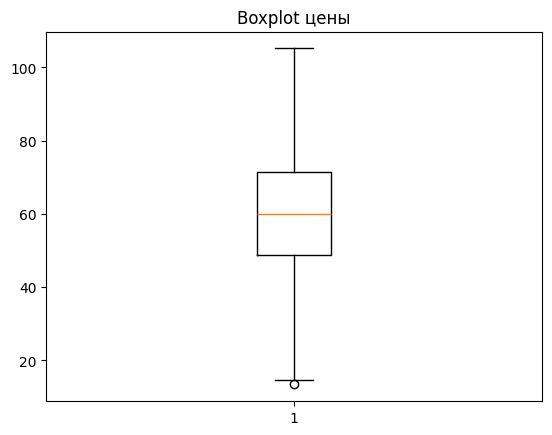

In [11]:
plt.boxplot(df['price'])
plt.title('Boxplot цены')
plt.show()

## 10. Ridge-регрессия
Модификация линейной регрессии, которая борется с мультиколлинеарностью.

Когда признаки линейно зависимы, Ridge улучшает устойчивость модели.

In [12]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_test)

(
    r2_score(y_test, pred_ridge),
    np.sqrt(mean_squared_error(y_test, pred_ridge))
)

(0.8936299188595832, np.float64(5.421292727820807))

## 11. Полиномиальная регрессия
Добавляет новые нелинейные признаки: квадраты, кубы, произведения.

Когда зависимость **не линейная** и модель должна быть гибче.

In [13]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)

lr_poly = LinearRegression()
lr_poly.fit(X_train_p, y_train_p)

pred_poly = lr_poly.predict(X_test_p)

(
    r2_score(y_test_p, pred_poly),
    np.sqrt(mean_squared_error(y_test_p, pred_poly))
)

(0.9150171368200918, np.float64(4.894771508576153))